In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import pickle
from collections import Counter

# Load the data

In [9]:
data = []
for i in range(35):
    try:
        for line in open("C:\Users\dell\LOCALDIR\part-00282\part-0000" + str(i), 'r'):
            data.append(json.loads(line))
    except IOError:
        continue

In [10]:
allKeys = []
for i in range(len(data)):
    for (key, val) in data[i].iteritems():
        allKeys.append(key)

In [11]:
dataFull = {}
for key in list(set(allKeys)):
    dataFull[key] = []

In [ ]:
for i in range(len(data)):
    if i % 100 == 0:
        print float(i)/len(data)
    for (key, val) in data[i].iteritems():
        dataFull[key].append(val)
        for (k, v) in dataFull.iteritems():
            if len(v) < i:
                dataFull[k].append(None)

In [ ]:
for (key, val) in dataFull.iteritems():
    print (key, len(val))

In [10]:
for (key, val) in dataFull.iteritems():
    if len(val) <= len(data):
        dataFull[key].append(None)

### Subset the data to include 120K rows

In [17]:
dataFullSub = {}
for (key, val) in dataFull.iteritems():
    dataFullSub[key] = val[:120000]

### Turn the data to a DF

In [18]:
df = pd.DataFrame(dataFullSub)

In [19]:
df['conv:::conv'].describe()

count    120000.000000
mean          0.000033
std           0.005773
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: conv:::conv, dtype: float64

In [20]:
df['click:::click'].describe()

count    120000.000000
mean          0.001675
std           0.040893
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: click:::click, dtype: float64

# Clean the data 

In [18]:
def naCount(data):
    naCount = {}
    for col in data.columns:
        colNa = 0
        for val in data[col].isnull():
            if val == True:
                colNa += 1
        naCount[col] = [colNa, '{:0.2f}%'.format((float(colNa)/len(data))*100)]

    return naCount

### Remove features with over 30% NA

In [23]:
na = naCount(df)

In [24]:
toRemove = [k for (k,v) in na.iteritems() if v[0] > 30000]

In [25]:
df = df.drop(toRemove, axis=1)

### Remove categorical features with only 1 class

In [ ]:
for i in range(df.shape[1]):
    try:
        length = len(Counter(df[df.columns[i]]).most_common())
        if length <= 3:
            print (df.columns[i], length)
            if length == 1:
                toRemove.append(df.columns[i])
    except TypeError:
        continue

In [27]:
toRemove1 = [d for d in df.columns if d in toRemove]

In [28]:
df = df.drop(toRemove1, axis=1)

### Remove variables that are highly unique (e.g IDs) 

In [29]:
toRemove2 = []
for i in range(df.shape[1]):
    if (('_id' in df.columns[i]) | (':id' in df.columns[i]) | ('Id' in df.columns[i])):
        toRemove2.append(df.columns[i])

In [30]:
idVar = {}
for val in toRemove2:
    try:
        idVar[val] = (float(len(df[val].unique()))/len(df[val]))*100
    except TypeError:
        continue

In [31]:
import operator

In [32]:
idVarSorted = sorted(idVar.items(), key=operator.itemgetter(1), reverse=True)

In [33]:
toRemove2 = [k for (k, v) in idVarSorted if v > 50]

In [34]:
df = df.drop(toRemove2, axis=1)

# Feature extraction   

go over each feature and extract properties with a potential to hold predictive power 

### Time stamp split

In [35]:
from datetime import datetime

In [36]:
year = []
month = []
day = []
hour = []
minute = []
second = []
for timeS in df['bidRequest:::timestamp']:
    tSplit = str(timeS).replace(':',' ').replace(',',' ').replace('-', ' ').replace('T', ' ')[:20].split()
    year.append(tSplit[0])
    month.append(tSplit[1])
    day.append(tSplit[2])
    hour.append(tSplit[3])
    minute.append(tSplit[4])
    second.append(tSplit[5])

In [37]:
df['year'] = year
df['month'] = month
df['day'] = day
df['hour'] = hour
df['minute'] = minute
df['second'] = second

In [38]:
df = df.drop('bidRequest:::timestamp', axis=1)

In [39]:
df = df.drop('year', axis=1)

### Turn hour to time of day

In [40]:
timeOfDay = []
for h in df.hour:
    h = int(h)
    if ((h > 8) & (h <= 12)):
        timeOfDay.append('Morning')
    elif ((h > 12) & (h <= 17)):
        timeOfDay.append('Noon')
    elif ((h > 17) & (h <= 20)):
        timeOfDay.append('Afternoon')
    else:
        timeOfDay.append('Night')

In [41]:
df['timeOfDay'] = timeOfDay

In [42]:
df = df.drop('hour', axis=1)

### Turn day to time of month 

In [43]:
timeOfMonth = []
for h in df.day:
    h = int(h)
    if ((h > 0) & (h <= 6)):
        timeOfMonth.append('Beginning')
    elif ((h > 6) & (h <= 12)):
        timeOfMonth.append('Middle')
    else:
        timeOfMonth.append('End')

In [44]:
df['timeOfMonth'] = timeOfMonth

In [45]:
df = df.drop('day', axis=1)

### Url and Page vars

In [46]:
url = []
for urlVar in df['bidRequest:::url']:
    if urlVar != None:
        
        if 'https:' in urlVar:
            i = 1
        else:
            i = 0
            
        if '//www3' in urlVar:
            temp = str(urlVar)[12+i:].split('.')[0]
        elif '//www2' in urlVar:
            temp = str(urlVar)[12+i:].split('.')[0]
        elif '//www' in urlVar:
            temp = str(urlVar)[11+i:].split('.')[0]
        elif '//engg' in urlVar:
            temp = str(urlVar)[12+i:].split('.')[0]
        elif '//eng' in urlVar:
            temp = str(urlVar)[11+i:].split('.')[0]
        elif '//mp3' in urlVar:
            temp = str(urlVar)[11+i:].split('.')[0]
        elif '//eni' in urlVar:
            temp = str(urlVar)[11+i:].split('.')[0]
        elif '//en' in urlVar:
            temp = str(urlVar)[10+i:].split('.')[0]
        elif '//mp' in urlVar:
            temp = str(urlVar)[10+i:].split('.')[0]
        elif '//m1' in urlVar:
            temp = str(urlVar)[10+i:].split('.')[0]
        elif '//mc' in urlVar:
            temp = str(urlVar)[10+i:].split('.')[0]
        elif '//m4' in urlVar:
            temp = str(urlVar)[10+i:].split('.')[0]
        elif '//my' in urlVar:
            temp = str(urlVar)[10+i:].split('.')[0]
        elif '//m' in urlVar:
            temp = str(urlVar)[9+i:].split('.')[0]
        elif '//hindi3' in urlVar:
            temp = str(urlVar)[14+i:].split('.')[0] 
        elif '//hindi' in urlVar:
            temp = str(urlVar)[13+i:].split('.')[0] 
        else:
            temp = str(urlVar)[7+i:].split('.')[0] 
            
        url.append(temp)
    
    else:
        url.append(None)

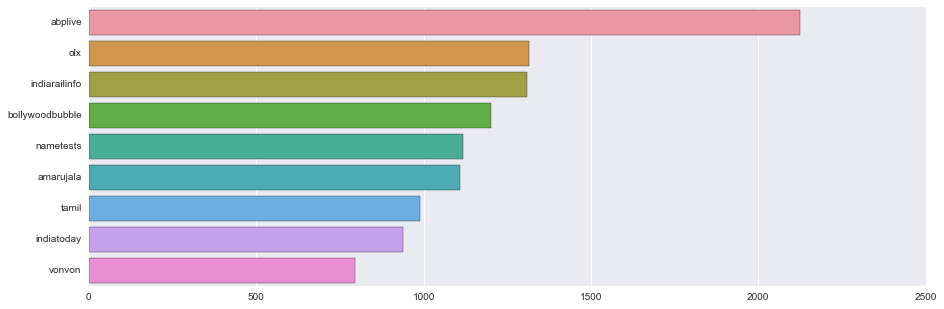

In [47]:
ax = sns.barplot(data=pd.DataFrame(Counter(url).most_common(10), columns=['x', 'y']), y='x', x='y')
sns.set(font_scale=4)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.show()

In [48]:
df['url'] = url

In [49]:
df = df.drop(['bidRequest:::url'], axis=1)

In [50]:
df = df.drop(['bidRequest:::site:::page'], axis=1)

### UserAgent var

In [51]:
def findBetween(s, first, last):
    start = s.rindex(first) + len(first)
    end = s.rindex(last, start)
    return s[start:end]

##### Android version

In [52]:
androidVersion = []
for v in df['bidRequest:::userAgent']:
    try:
        d = findBetween(str(v), 'Android', "Build").split()[0][:-1]
        if ';' in d:
            androidVersion.append(d.split(';')[0])
        elif d == 'SD':
            androidVersion.append(None)
        elif d == 22:
            androidVersion.append(None)
        else:
            androidVersion.append(d)
    except:
        androidVersion.append(None)

In [53]:
df['androidVersion'] = androidVersion

##### AppleWebKit

In [54]:
AppleWebKit = []
for v in df['bidRequest:::userAgent']:
    try:
        AppleWebKit.append(str(findBetween(str(v), "AppleWebKit", "(").split()[0])[1:])
    except:
        AppleWebKit.append(None)

In [55]:
df['appleWebKit'] = AppleWebKit

##### Chrome version

In [70]:
Chrome = df['bidRequest:::device:::osv']

In [ ]:
Chrome = []
for v in df['bidRequest:::userAgent']:
    if 'Chrome' in v:
        try:
            Chrome.append(str(findBetween(str(v), "Chrome", "Safari").split()[0])[1:])
        except ValueError:
            Chrome.append(str(findBetween(str(v), "Chrome", "").split()[0])[1:])
    else:
        Chrome.append(None)

In [71]:
df['chrome'] = Chrome

##### Safari

In [ ]:
df.iloc[0]

In [ ]:
safari = []
for v in df['bidRequest:::userAgent']:
    if 'Safari' in v:
        try:
            d = str(findBetween(str(v), "Safari", "").split()[0])[1:7]
            if "[" in d:
                safari.append(str(findBetween(str(v), "Safari", "[").split()[0])[1:])
            else:
                if d[-1] == '/':
                    safari.append(d[:-1])
                else:
                    safari.append(d)
        except IndexError:
            safari.append(None)
    else:
        safari.append(None)

In [93]:
df['safari'] = safari

In [76]:
df = df.drop(['bidRequest:::userAgent'], axis=1)

### click_through_rate

In [79]:
click_through_rate = []
for item in df['bidRequest:::imp:::ext:::click_through_rate']:
    if str(item).isalpha():
        click_through_rate.append(None)
    else:
        click_through_rate.append(item)

In [80]:
df['click_through_rate'] = click_through_rate

In [81]:
df = df.drop('bidRequest:::imp:::ext:::click_through_rate', axis=1)

### Win price

In [112]:
wPrice = []
for price in df.winPrice:
    wPrice.append(int(str(price).replace('USD/', ' ').split()[0]))

In [113]:
df.winPrice = wPrice

### UA

In [114]:
ua = []
for item in df['bidRequest:::device:::ua']:
    try:
        ua.append(item.split(':')[0])
    except AttributeError:
        ua.append(None)

In [115]:
df['ua'] = ua

In [116]:
df = df.drop('bidRequest:::device:::ua', axis=1)

### Convert res to pixel number

In [117]:
pixelNumber = []
for res in df['bidRequest:::device:::ext:::res']:
    pixelNumber.append(int(res.split('x')[0]) * int(res.split('x')[1]))

In [118]:
df.pixelNumber = pixelNumber

In [119]:
df = df.drop('bidRequest:::device:::ext:::res', axis=1)

### Screen size

In [120]:
screenSize = []
for (h, w) in zip(df['bidRequest:::device:::ext:::screen_height'], df['bidRequest:::device:::ext:::screen_width']):
    screenSize.append(h*w)

In [121]:
df.screenSize = screenSize

In [122]:
df = df.drop('bidRequest:::device:::ext:::screen_height', axis=1)

In [123]:
df = df.drop('bidRequest:::device:::ext:::screen_width', axis=1)

### Timezone offset

In [124]:
timezoneOffset = []
for item in df['bidRequest:::device:::ext:::timezone_offset']:
    if str(item).isalpha():
        timezoneOffset.append(None)
    else:
        timezoneOffset.append(item)

In [125]:
df.timezoneOffset = timezoneOffset

In [126]:
df = df.drop('bidRequest:::device:::ext:::timezone_offset', axis=1)

### Bid price

In [127]:
bidPrice = []
for price in df.bidPrice:
    bidPrice.append(int(str(price).replace('USD/', ' ').split()[0]))

In [128]:
df.bidPrice = bidPrice

### viewability

In [129]:
viewability = []
for item in df['bidRequest:::imp:::ext:::viewability']:
    if str(item).isalpha():
        viewability.append(None)
    else:
        viewability.append(item)

In [130]:
df['viewability'] = viewability

In [131]:
df = df.drop('bidRequest:::imp:::ext:::viewability', axis=1)

### publisher type

In [132]:
publisherType = []
for item in df['bidRequest:::site:::publisher:::ext:::publisher_type']:
    if str(item).isalpha():
        publisherType.append(None)
    else:
        publisherType.append(item)

In [133]:
df['publisherType'] = publisherType

In [134]:
df = df.drop('bidRequest:::site:::publisher:::ext:::publisher_type', axis=1)

### is_mobile_web_optimized

In [135]:
is_mobile_web_optimized = []
for item in df['bidRequest:::device:::ext:::is_mobile_web_optimized']:
    if item == None:
        is_mobile_web_optimized.append(False)
    else:
        is_mobile_web_optimized.append(item)

In [136]:
df['is_mobile_web_optimized'] = is_mobile_web_optimized

In [137]:
df = df.drop('bidRequest:::device:::ext:::is_mobile_web_optimized', axis=1)

### iframing_state

In [138]:
iframing_state = []
for item in df['bidRequest:::imp:::ext:::iframing_state']:
    if str(item).isalpha():
        iframing_state.append(None)
    else:
        iframing_state.append(item)

### Vars to remove due to redundency

Either duplicates or simply redundant 

In [155]:
df = df.drop('bidRequest:::imp:::ext:::iframing_state', axis=1)

In [156]:
df = df.drop(['bidRequest:::device:::geo:::lon', 'bidRequest:::device:::geo:::lat'], axis=1)

In [157]:
df = df.drop('bidRequest:::segments:::dup:::ifa', axis=1)

In [119]:
df = df.drop('bidRequest:::device:::model', axis=1)

In [120]:
df = df.drop('bidRequest:::site:::publisher:::id', axis=1)

In [121]:
df = df.drop('bidRequest:::imp:::pmp:::ext:::partner_id', axis=1)

In [122]:
df = df.drop('bidRequest:::site:::id', axis=1)

In [158]:
df = df.drop('bidRequest:::segments:::dup:::deviceMake', axis=1)

In [159]:
df = df.drop('bidRequest:::segments:::dup:::carrier', axis=1)

In [160]:
df = df.drop('bidRequest:::device:::language', axis=1)

In [161]:
df = df.drop('bidRequest:::device:::osv', axis=1)

In [162]:
df = df.drop('bidRequest:::device:::geo:::city', axis=1)

In [163]:
df = df.drop('bidRequest:::segments:::dup:::osv', axis=1)

In [129]:
df = df.drop('bidRequest:::location:::regionCode', axis=1)

In [131]:
df = df.drop('augmentations:::frequency-cap:::tags', axis=1)

In [164]:
df = df.drop('bidRequest:::imp:::banner:::h', axis=1)

In [165]:
df = df.drop('bidRequest:::imp:::banner:::w', axis=1)

In [134]:
df = df.drop('bidRequest:::imp:::formats', axis=1)

In [135]:
df = df.drop('bidRequest:::imp:::tagid', axis=1)

In [166]:
df = df.drop('bidRequest:::segments:::AdxDetectedVerticals', axis=1)

In [167]:
df = df.drop('minute', axis=1)

In [168]:
df = df.drop('second', axis=1)

In [139]:
df = df.drop('bidRequest:::device:::ext:::geo_criteria_id', axis=1)

In [169]:
df = df.drop('androidVersion', axis=1)

### Pickle

In [8]:
df.to_pickle('kamilRaw1')

In [25]:
df = pd.read_pickle('kamilRaw1')

# Data types

Make sure the feature vectors are categorized correctly in terms of their data type (e.g. numeric, categorical etc.)

##### Categorical

In [26]:
df['bidRequest:::device:::geo:::region'] = pd.Categorical(df['bidRequest:::device:::geo:::region'])

In [27]:
turnToCat = ['ua', 'account', 'augmentations:::frequency-cap:::data:::option', 'bidRequest:::device:::carrier',
            'bidRequest:::device:::geo:::region', 'bidRequest:::device:::ip', 'bidRequest:::device:::make',
            'augmentations:::frequency-cap:::data:::option',  'bidRequest:::imp:::banner:::pos', 'bidRequest:::language',
             'bidRequest:::location:::cityName', 'creativeId',
            'bidRequest:::publisherType', 'bidRequest:::segments:::dup:::isInterstitial', 'url',
             'appleWebKit', 'chrome', 'is_mobile_web_optimized', 'publisherType', 'timeOfDay', 'timeOfMonth',
            'bidRequest:::segments:::dup:::deviceModel','month', 'day','hour','safari', 'androidVersion']

In [28]:
for col in turnToCat:
    if col == 'day':
        break
    else:
        df[col] = pd.Categorical(df[col])

In [11]:
for col in df.columns:
    try:
        print (col, df[col].dtype.name, len(df[col].unique()))
    except TypeError:
        print (col)

(u'account', 'category', 23)
(u'augmentations:::frequency-cap:::data:::count', 'int64', 15)
(u'augmentations:::frequency-cap:::data:::option', 'category', 2)
(u'bidPrice', 'int64', 22)
(u'bidRequest:::device:::carrier', 'category', 13)
(u'bidRequest:::device:::ext:::device_pixel_ratio_millis', 'int64', 37)
(u'bidRequest:::device:::geo:::region', 'category', 9)
(u'bidRequest:::device:::ip', 'category', 18882)
(u'bidRequest:::device:::make', 'category', 145)
(u'bidRequest:::imp:::banner:::pos', 'category', 3)
(u'bidRequest:::language', 'category', 49)
(u'bidRequest:::location:::cityName', 'category', 10)
(u'bidRequest:::publisherType', 'category', 2)
(u'bidRequest:::segments:::dup:::deviceModel', 'category', 1967)
(u'bidRequest:::segments:::dup:::isInterstitial', 'category', 2)
(u'bidRequest:::user:::ext:::cookie_age_seconds', 'float64', 80)
(u'click:::click', 'int64', 2)
(u'conv:::conv', 'int64', 2)
(u'creativeId', 'category', 27)
(u'winPrice', 'int64', 206)
('month', 'category', 1)
('t

# Predictions

##### Due to the fact that the two classes are extremely imbalanced and the sparse nature of the problem I will try two different model fitting approaches

First approach:

1.	One-hot-encoding
2.	Scaling with MinMax scaler (for the non dummy variables)
3.	Preform PCA for dimensionality reduction. Generate PCs to capture 95% of the variance in the data.
4.	Train-Test split 
5.	K-Means clustering only on the X training data with y = 0 label (with number of centroids = the length of X_train | y=1)
6.	Train the model only on the X train data that has y = 1 label and the centroids of the K-Means.
7.	Test on the original subset of the PCA that was not used in the training proses.

Second approach:

1.	One-hot-encoding
2.	Scaling with MinMax scaler (for the non dummy variables)
3.	Preform PCA for dimensionality reduction. Generate PCs to capture 95% of the variance in the data.
4.	Train-Test split 
5.	Add class weights to the predictions (the weights will be the ratio of 0 labels to 1 in the data)
6.	Test on the original subset of the PCA that was not used in the training proses.


# First approach

In [22]:
X = df.drop(['bidRequest:::segments:::dup:::deviceModel', 'url', 'bidRequest:::device:::ip', 'winPrice', 'bidPrice'], axis=1)

For working locally and not having enough "fire power" I have to drop:

1.	bidRequest:::segments:::dup:::deviceModel'
2.	'url'
3.	'bidRequest:::device:::ip'

'winPrice' and 'bidPrice' were dropped because they chronologically can't be used  for prediction 


In [24]:
xDum = pd.get_dummies(X, dummy_na=True)

Due to the fact that I have been dealing with a very small subset of the data (working locally) I will be predicting clicks and not conversations, as the entire subset contains only 4 positive conversations (4 / 120K)

In [14]:
y = xDum['click:::click']

In [15]:
xDum = xDum.drop(['click:::click', 'conv:::conv'], axis=1)

# Dimensionality reduction

### Scaling and NA removal from numeric columns

In [34]:
numericCols = []
for col in xDum.columns[:5]:
    numericCols.append(col)

In [28]:
naCount(xDum[numericCols])

{u'augmentations:::frequency-cap:::data:::count': [0, '0.00%'],
 u'bidRequest:::device:::ext:::device_pixel_ratio_millis': [0, '0.00%'],
 u'bidRequest:::user:::ext:::cookie_age_seconds': [1881, '1.57%'],
 'click_through_rate': [17223, '14.35%'],
 'viewability': [2062, '1.72%']}

In [ ]:
new = {'augmentations:::frequency-cap:::data:::count': [], 'bidRequest:::device:::ext:::device_pixel_ratio_millis': [],
       'bidRequest:::user:::ext:::cookie_age_seconds': [],
       'click_through_rate': [], 'viewability': []}
for col in numericCols:
    median = np.median(xDum[col].dropna())
    for (val, na) in zip(xDum[col], xDum[col].isnull()):
        if na == True:
            new[col].append(median)
        else:
            new[col].append(val)

In [ ]:
for col in numericCols:
    xDum[col] = new[col]

In [31]:
naCount(xDum[numericCols])

{u'augmentations:::frequency-cap:::data:::count': [0, '0.00%'],
 u'bidRequest:::device:::ext:::device_pixel_ratio_millis': [0, '0.00%'],
 u'bidRequest:::user:::ext:::cookie_age_seconds': [0, '0.00%'],
 'click_through_rate': [0, '0.00%'],
 'viewability': [0, '0.00%']}

### Scale (MinMax)

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
XScaled = pd.DataFrame(MinMaxScaler().fit_transform(xDum), columns=xDum.columns)

### Plot PCA

In [24]:
xPca = PCA(n_components=2).fit_transform(XScaled)

In [25]:
pcaDf = pd.DataFrame(xPca, columns=['PC1', 'PC2'])

In [26]:
pcaDf['y'] = y

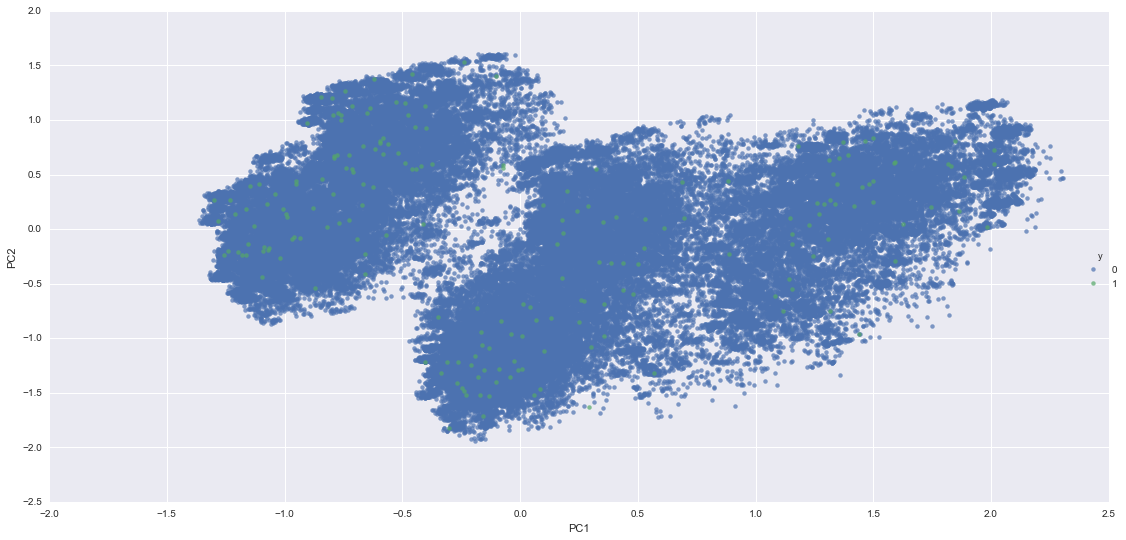

In [27]:
ax = sns.lmplot(data=pcaDf, x='PC1', y='PC2', hue='y', size=30, aspect=5, fit_reg=False, scatter_kws={'alpha': 0.7})
fig = plt.gcf()
fig.set_size_inches(15, 7)

### Select number of components so it'll capture 95% of the variance

In [174]:
xPca = PCA().fit(XScaled)

In [175]:
nComp = xPca.explained_variance_ratio_.cumsum()

In [176]:
list(nComp).index([min(nComp, key=lambda x:abs(x-0.95))])

63

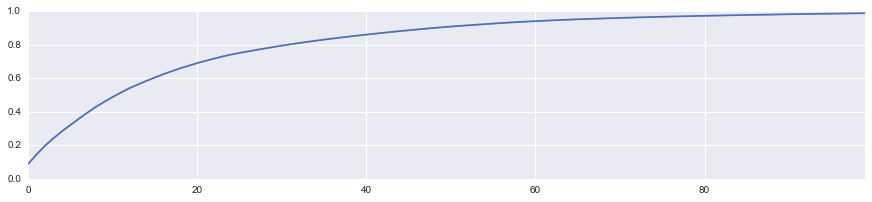

In [177]:
ax = sns.tsplot(nComp[:100])
fig = plt.gcf()
fig.set_size_inches(15, 3)

In [178]:
xPca = PCA(n_components=63).fit_transform(XScaled)

### Train-Test split

In [179]:
xPca = pd.DataFrame(xPca)

In [180]:
xPca['y'] = y

In [181]:
index = np.array(range(len(xPca)))

In [ ]:
trainIndex = np.random.choice(index, replace=False, size=0.8*len(index))

In [185]:
testIndex = [n for n in range(len(xPca)) if n not in trainIndex]

In [192]:
X_train = xPca.iloc[trainIndex]

In [193]:
X_test = xPca.iloc[testIndex]

In [194]:
Counter(X_train.y).most_common(), Counter(X_test.y).most_common()

([(0, 95829), (1, 171)], [(0, 23970), (1, 30)])

In [195]:
y_test = X_test.y

In [196]:
X_test = X_test.drop('y', axis=1)

### K-Means

In [197]:
from sklearn.cluster import KMeans

In [198]:
X_train = pd.DataFrame(X_train)

In [199]:
len(X_train[X_train['y'] == 1])

171

In [200]:
kmMod = KMeans(n_clusters=171, verbose=2)

In [ ]:
xPcaKmeans = kmMod.fit(X_train[X_train['y'] == 0])

In [202]:
X_train = X_train[X_train['y'] == 1]

In [203]:
centroids = pd.DataFrame(xPcaKmeans.cluster_centers_)

##### Pickle the centroids

In [204]:
centroids.to_pickle('centroidsSub')

In [118]:
centroids = pd.read_pickle('centroidsSub')

In [51]:
centroids = pd.read_pickle('centroids')

##### Continue

In [209]:
centroids = centroids.drop(63, axis=1)

In [211]:
centroids['y'] = 0

In [213]:
X_train = X_train.append(centroids)

In [214]:
y_train = X_train.y

In [215]:
X_train = X_train.drop('y', axis=1)

In [216]:
Counter(y_train).most_common()

[(0, 171), (1, 171)]

# Model Training

In [217]:
def plotCvRocCurve(X, y, classifier, nfolds=5):
    
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold
    import matplotlib.pyplot as plt
    from scipy import interp

    cv = StratifiedKFold(y, n_folds=nfolds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CV ROC curve')
    plt.legend(loc="lower right")
    fig = plt.gcf()
    fig.set_size_inches(15,5)

    plt.show()

def rocZeroOne(y_true, y_predicted_porba):
    
    from sklearn.metrics import roc_curve
    from scipy.spatial.distance import euclidean
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted_porba[:, 1])
    
    best = [0, 1]
    dist = []
    for (x, y) in zip(fpr, tpr):
        dist.append([euclidean([x,y], best)])

    bestPoint = [fpr[dist.index(min(dist))], tpr[dist.index(min(dist))]]
    
    bestCutOff1 = thresholds[list(fpr).index(bestPoint[0])]
    bestCutOff2 = thresholds[list(tpr).index(bestPoint[1])]
    
    print '\n' + 'Best point on the ROC: TPR = {:0.3f}%, FPR = {:0.3f}%'.format(bestPoint[1]*100, bestPoint[0]*100)
    print '\n' + 'Best Cut-Off point: {:0.4f}'.format(bestCutOff1)

    plt.plot(dist)
    plt.xlabel('Index')
    plt.ylabel('Euclidean Distance to the perfect [0,1]')
    fig = plt.gcf()
    fig.set_size_inches(15,5)

In [218]:
def plot_confusion_matrix(yTrue, yPred, title = 'Confusion matrix', cmap=plt.cm.Blues):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print 'Classification Report:\n'
    print classification_report(yTrue, yPred)
    cm = confusion_matrix(yTrue, yPred)
    def plot_confusion_matrix_plot(cm, title = 'Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(yTrue.unique()))
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    print '\n Confusion matrix, without normalization: \n'
    print cm
    plot_confusion_matrix_plot(cm=cm)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('\n Normalized confusion matrix \n')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix_plot(cm_normalized, title='Normalized confusion matrix')

def makePredThresh(fittedCls, thr = 0.5, X_test = X_test):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

In [219]:
def pred(thr, predProba):
    predT = []
    for v in predProba[:,1]:
        if v > thr:
            predT.append(1)
        else:
            predT.append(0)
    return predT

In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC
from scipy.stats import randint

### Plot the data

##### PCA

In [221]:
dong = PCA(n_components=2).fit_transform(X_train)

dong = pd.DataFrame(dong, columns=['PC1', 'PC2'])

yTrainCopy = pd.DataFrame(y_train)

yTrainCopy.index = range(len(yTrainCopy))

dong['y'] = yTrainCopy

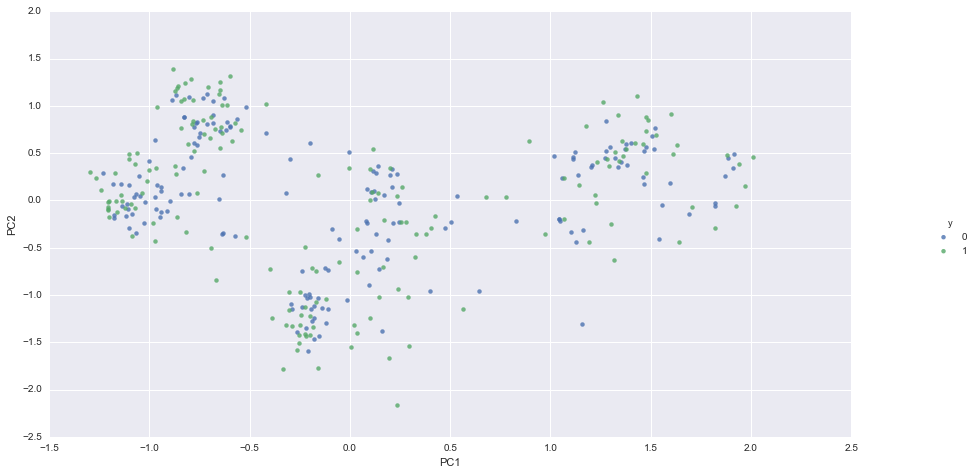

In [222]:
ax = sns.lmplot(data=dong, x='PC1', y='PC2', hue='y', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 7)

##### LDA - shrinkage

In [223]:
ldaModS = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', priors=None, n_components=2,
                                    store_covariance=False, tol=0.0001)

In [224]:
fittedLdaModS = ldaModS.fit(X_train, y_train).transform(X_train)

ldaDfS = pd.DataFrame(fittedLdaModS, columns=['one', 'two'])

ldaDfS['cat'] = yTrainCopy

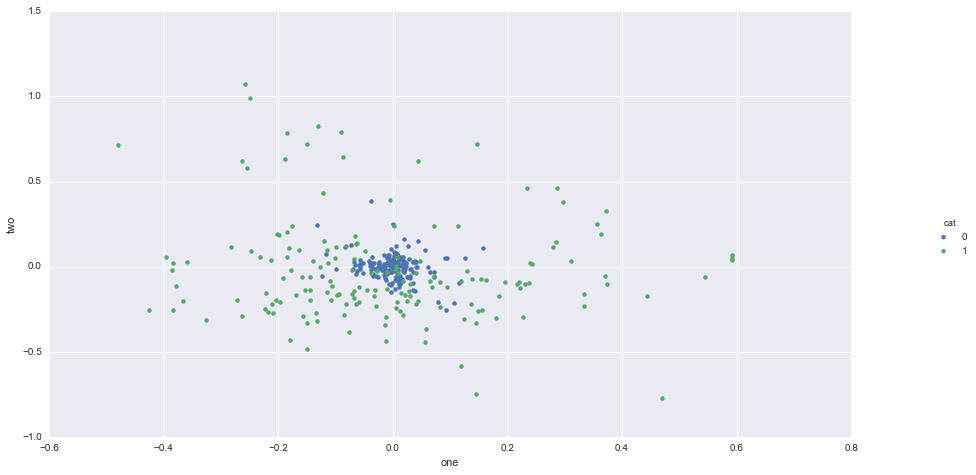

In [225]:
ax = sns.lmplot(data = ldaDfS, x='one', y='two', hue='cat', fit_reg=False, scatter_kws={'alpha': 1})
fig = plt.gcf()
fig.set_size_inches(15, 7)

##### LDA

In [226]:
ldaModS = LinearDiscriminantAnalysis(solver='eigen', shrinkage=None, priors=None, n_components=2,
                                    store_covariance=False, tol=0.0001)

In [227]:
fittedLdaModS = ldaModS.fit(X_train, y_train).transform(X_train)

In [228]:
ldaDf = pd.DataFrame(fittedLdaModS, columns=['one', 'two'])

ldaDf['cat'] = yTrainCopy

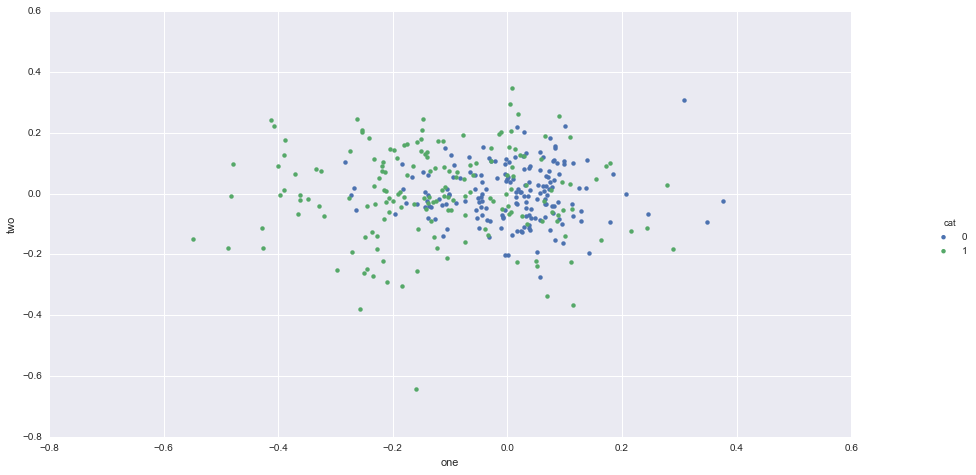

In [229]:
ax = sns.lmplot(data = ldaDf, x='one', y='two', hue='cat', fit_reg=False, scatter_kws={'alpha': 1})
fig = plt.gcf()
fig.set_size_inches(15, 7)

### Make custom score function 

The custom score function is designed to return the point of minimal distance from the optimal point [0,1] on the ROC curve plotted on the test  data and the classifier generated in each iteration.  

This method is necessary due to the fact that regular CV on the training set will not yield a significantly good result, that is because the test and train data are different in nature.

In [368]:
from sklearn.metrics import make_scorer

In [422]:
def minRocZeroOne(y, y_pred):
    
    from sklearn.metrics import roc_curve
    from scipy.spatial.distance import euclidean
    
    fpr, tpr, thresholds = roc_curve(y, y_pred[:, 1])
    
    best = [0, 1]
    dist = []
    for (x, y) in zip(fpr, tpr):
        dist.append([euclidean([x,y], best)])
    
    return min(dist)[0]

In [423]:
costumScore = make_scorer(minRocZeroOne, greater_is_better=False, needs_proba=True)

### LogisticRegression

In [499]:
lmMod = LogisticRegression()

In [500]:
lmHyperParams = {'penalty': ['l1', 'l2'],
                  'C': randint(1, 500),
                  'fit_intercept': [True, False]}

In [509]:
gridSearchLm = RandomizedSearchCV(estimator=lmMod, param_distributions=lmHyperParams, n_iter=100,
                                   scoring=costumScore, fit_params=None, cv=10, verbose=0).fit(X_train, y_train)

In [510]:
gridSearchLm.best_params_, minRocZeroOne(y_test, gridSearchLm.best_estimator_.predict_proba(X_test))

({'C': 44, 'fit_intercept': True, 'penalty': 'l2'}, 0.5767065721770991)

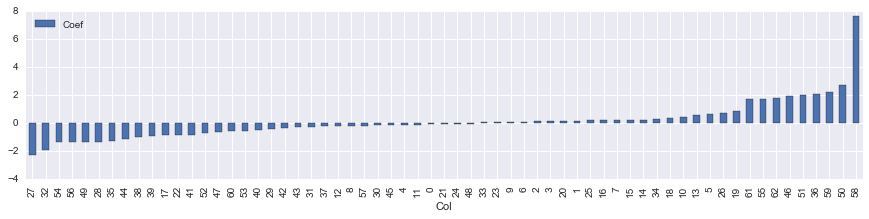

In [511]:
coefDf = pd.DataFrame(zip(gridSearchLm.best_estimator_.coef_[0], X_train.columns), columns=['Coef', 'Col'])
ax = coefDf.sort_values(by='Coef').plot(kind='bar', x='Col', y='Coef')
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.show()


Best point on the ROC: TPR = 53.333%, FPR = 33.884%

Best Cut-Off point: 0.5789


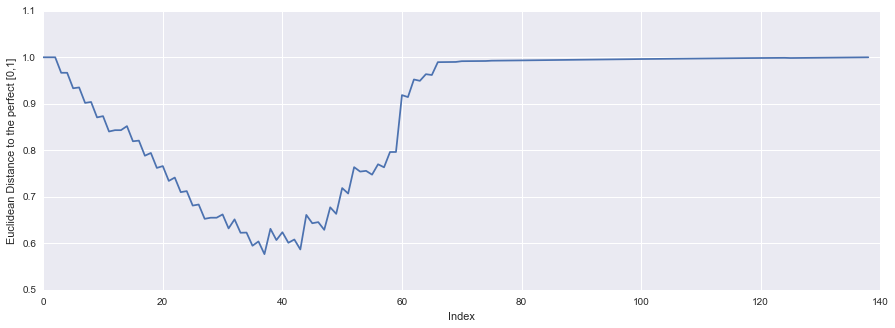

In [512]:
rocZeroOne(y_test, gridSearchLm.best_estimator_.predict_proba(X_test))

Classification Report:

             precision    recall  f1-score   support

          0       1.00      0.66      0.80     23970
          1       0.00      0.50      0.00        30

avg / total       1.00      0.66      0.79     24000


 Confusion matrix, without normalization: 

[[15850  8120]
 [   15    15]]

 Normalized confusion matrix 

[[ 0.66124322  0.33875678]
 [ 0.5         0.5       ]]


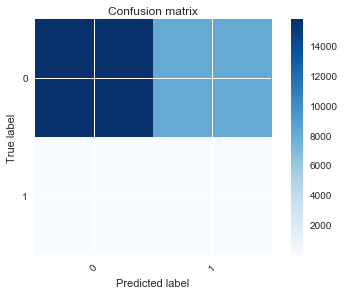

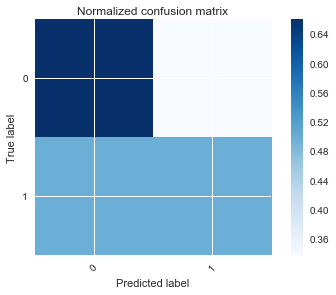

In [513]:
proba = gridSearchLm.best_estimator_.predict_proba(X_test)

yHat = pred(0.5789, gridSearchLm.best_estimator_.predict_proba(X_test))

plot_confusion_matrix(y_test, yHat)

### SVM

In [469]:
svcMod = SVC(probability=True, verbose=False).fit(X_train, y_train)

In [471]:
svcparamDist = {'C': randint(1,1000),
               'kernel': ['poly', 'rbf', 'sigmoid'],
               'degree': randint(1,5),
               'shrinking': [True, False]}

In [474]:
gridSearchSvm = RandomizedSearchCV(estimator=svcMod, param_distributions=svcparamDist, n_iter=25,
                                   scoring=costumScore).fit(X_train, y_train)

In [475]:
gridSearchSvm.best_params_, minRocZeroOne(y_test, gridSearchSvm.best_estimator_.predict_proba(X_test))

({'C': 811, 'degree': 3, 'kernel': 'rbf', 'shrinking': False},
 0.6801820812350321)


Best point on the ROC: TPR = 56.667%, FPR = 52.428%

Best Cut-Off point: 1.0000


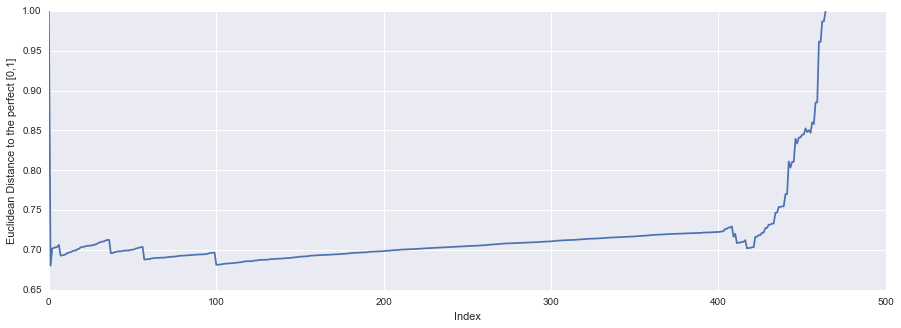

In [476]:
rocZeroOne(y_test, gridSearchSvm.best_estimator_.predict_proba(X_test))

### AdaBoostClassifier

In [333]:
adaMod = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

In [480]:
hParams = {'algorithm': ['SAMME', 'SAMME.R'],
          'n_estimators': randint(50,300),
          'learning_rate': randint(1,5)}

In [481]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=hParams, n_iter=10,
                                   scoring=costumScore).fit(X_train, y_train)

In [483]:
gridSearchAda.best_params_, minRocZeroOne(y_test, gridSearchAda.best_estimator_.predict_proba(X_test))

({'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 243},
 0.6912039574339711)


Best point on the ROC: TPR = 60.000%, FPR = 56.370%

Best Cut-Off point: 0.7226


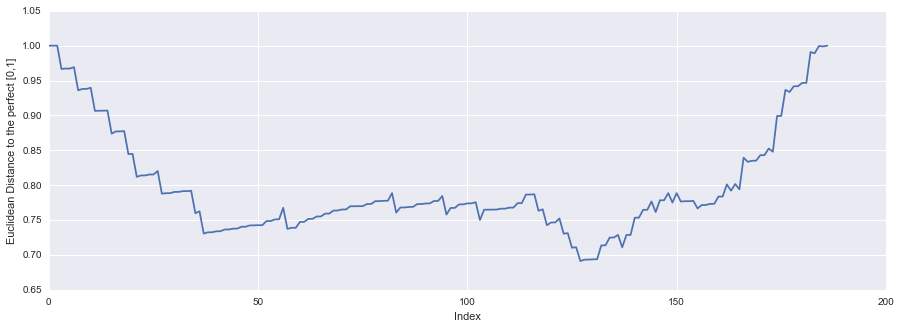

In [482]:
rocZeroOne(y_test, gridSearchAda.best_estimator_.predict_proba(X_test))

Classification Report:

             precision    recall  f1-score   support

          0       1.00      0.44      0.61     23970
          1       0.00      0.57      0.00        30

avg / total       1.00      0.44      0.61     24000


 Confusion matrix, without normalization: 

[[10465 13505]
 [   13    17]]

 Normalized confusion matrix 

[[ 0.4365874   0.5634126 ]
 [ 0.43333333  0.56666667]]


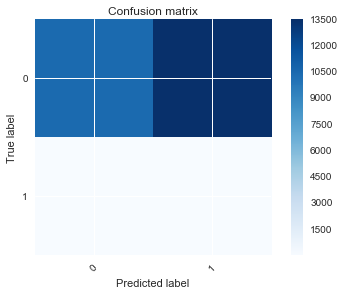

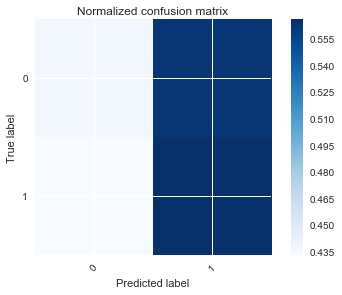

In [485]:
yHat = pred(0.7226, gridSearchAda.best_estimator_.predict_proba(X_test))

plot_confusion_matrix(y_test, yHat)

### RandomForestClassifier

In [486]:
rfMod = RandomForestClassifier(verbose=0).fit(X_train, y_train)

In [487]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              'n_estimators': randint(1,10),
              "min_samples_split": randint(1, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [488]:
randomSearchRf = RandomizedSearchCV(rfMod, param_distributions=param_dist, n_iter=25, scoring=costumScore)\
.fit(X_train, y_train)

In [489]:
randomSearchRf.best_params_, minRocZeroOne(y_test, randomSearchRf.best_estimator_.predict_proba(X_test))

({'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': 3,
  'max_features': 6,
  'min_samples_leaf': 3,
  'min_samples_split': 1,
  'n_estimators': 7},
 0.661347535823343)


Best point on the ROC: TPR = 63.333%, FPR = 55.040%

Best Cut-Off point: 0.8065


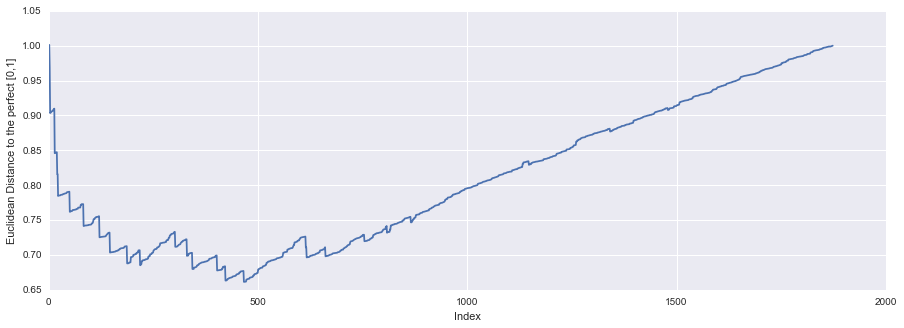

In [490]:
rocZeroOne(y_test, randomSearchRf.best_estimator_.predict_proba(X_test))

Classification Report:

             precision    recall  f1-score   support

          0       1.00      0.45      0.62     23970
          1       0.00      0.60      0.00        30

avg / total       1.00      0.45      0.62     24000


 Confusion matrix, without normalization: 

[[10876 13094]
 [   12    18]]

 Normalized confusion matrix 

[[ 0.45373383  0.54626617]
 [ 0.4         0.6       ]]


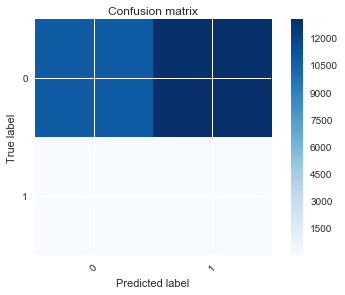

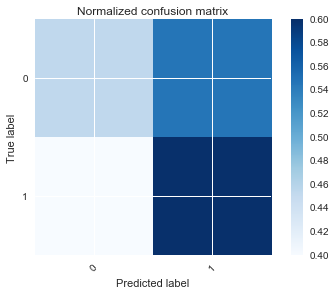

In [491]:
yHat = pred(0.8065, randomSearchRf.best_estimator_.predict_proba(X_test))

plot_confusion_matrix(y_test, yHat)

### GradientBoostingClassifier

In [492]:
gbMod = GradientBoostingClassifier().fit(X_train, y_train)

In [493]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(50,300),
                  "max_features": randint(1, 11),
                  "min_samples_split": randint(1, 11),
                  "min_samples_leaf": randint(1, 11)}

In [495]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=25,
                                   scoring=costumScore, fit_params=None, cv=None, verbose=0).fit(X_train, y_train)

In [496]:
gridSearchGB.best_params_, minRocZeroOne(y_test, gridSearchGB.best_estimator_.predict_proba(X_test))

({'loss': 'exponential',
  'max_features': 10,
  'min_samples_leaf': 9,
  'min_samples_split': 6,
  'n_estimators': 128},
 0.7298564067748831)


Best point on the ROC: TPR = 80.000%, FPR = 70.192%

Best Cut-Off point: 1.0000


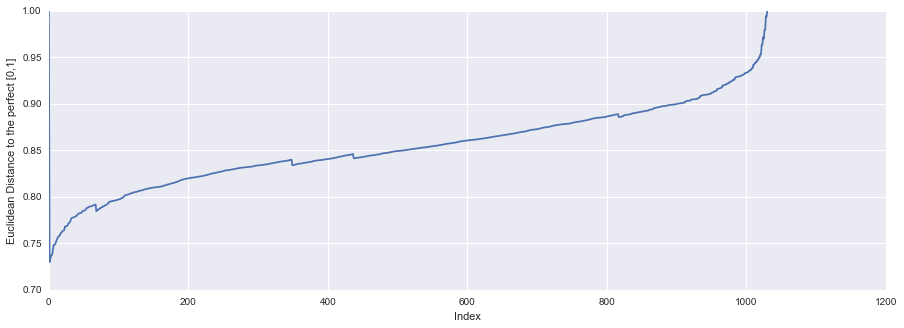

In [497]:
rocZeroOne(y_test, gridSearchGB.best_estimator_.predict_proba(X_test))

# Second approach

### Train-Test split

In [514]:
from sklearn.cross_validation import train_test_split

In [515]:
X = xPca.drop('y', axis=1)

In [516]:
y = xPca.y

In [521]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Plot the data

In [267]:
ldaModS = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', priors=None, n_components=2,
                                    store_covariance=False, tol=0.0001)

In [268]:
fittedLdaModS = ldaModS.fit(X_train, y_train).transform(X_train)

ldaDfS = pd.DataFrame(fittedLdaModS, columns=['one', 'two'])

ldaDfS['cat'] = yTrainCopy

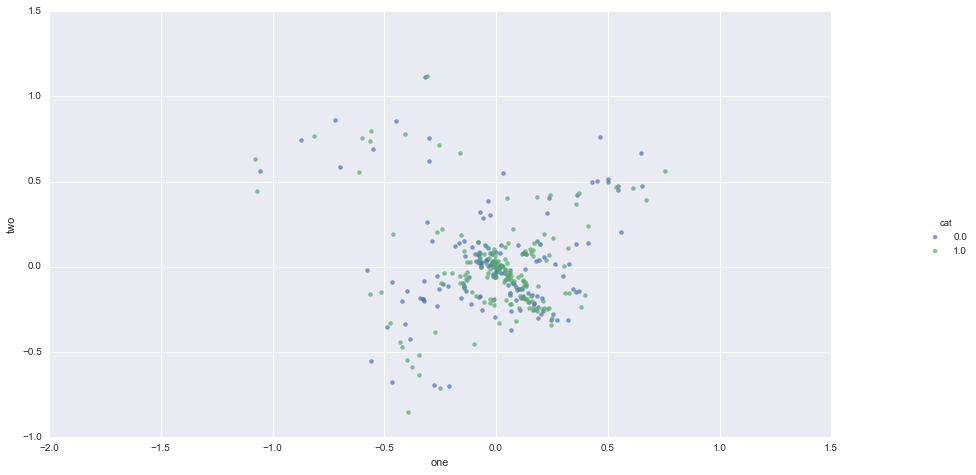

In [271]:
ax = sns.lmplot(data = ldaDfS, x='one', y='two', hue='cat', fit_reg=False, scatter_kws={'alpha': 0.7})
fig = plt.gcf()
fig.set_size_inches(15, 7)

In [272]:
ldaModS = LinearDiscriminantAnalysis(solver='eigen', shrinkage=None, priors=None, n_components=2,
                                    store_covariance=False, tol=0.0001)

In [273]:
fittedLdaModS = ldaModS.fit(X_train, y_train).transform(X_train)

ldaDfS = pd.DataFrame(fittedLdaModS, columns=['one', 'two'])

ldaDfS['cat'] = yTrainCopy

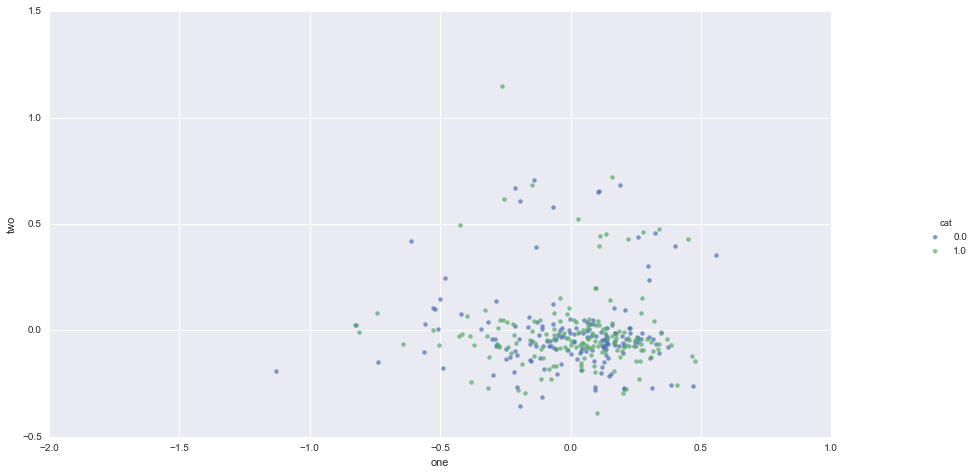

In [274]:
ax = sns.lmplot(data = ldaDfS, x='one', y='two', hue='cat', fit_reg=False, scatter_kws={'alpha': 0.7})
fig = plt.gcf()
fig.set_size_inches(15, 7)

##### PCA

In [275]:
dong = PCA(n_components=2).fit_transform(X_train)

dong = pd.DataFrame(dong, columns=['PC1', 'PC2'])

yTrainCopy = pd.DataFrame(y_train)

yTrainCopy.index = range(len(yTrainCopy))

dong['y'] = yTrainCopy

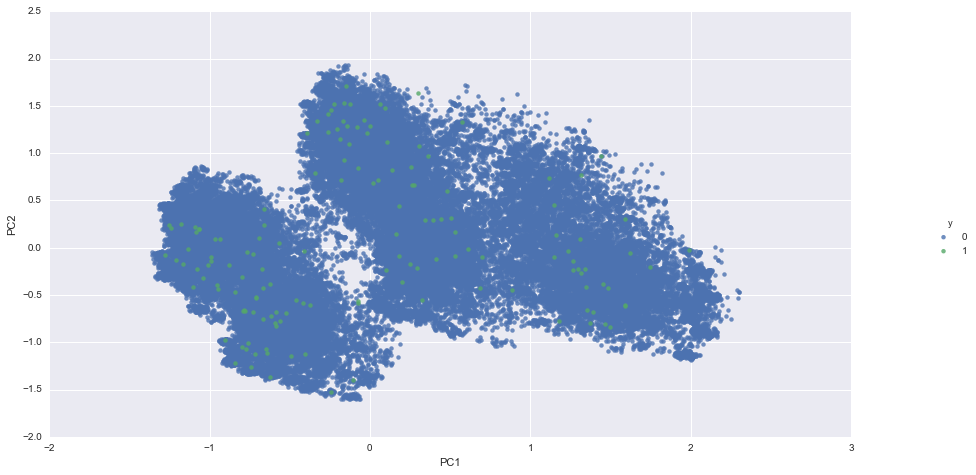

In [276]:
ax = sns.lmplot(data=dong, x='PC1', y='PC2', hue='y', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 7)

### LogisticRegression

In [522]:
Counter(y_train).most_common()

[(0, 95837), (1, 163)]

In [523]:
weight = 95837./163

In [524]:
lmMod = LogisticRegression(class_weight={1: weight}).fit(X_train, y_train)

In [525]:
lmHyperParams = {'penalty': ['l1', 'l2'],
                  'C': randint(1,100),
                  'fit_intercept': [True, False]}

In [526]:
gridSearchLm = RandomizedSearchCV(estimator=lmMod, param_distributions=lmHyperParams, n_iter=25,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=0).fit(X_train, y_train)

In [569]:
gridSearchLm.best_params_

{'C': 54, 'fit_intercept': True, 'penalty': 'l2'}

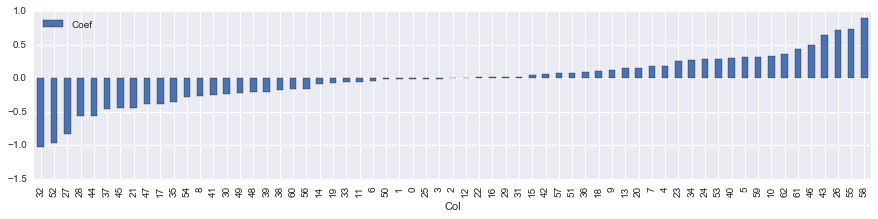

In [528]:
coefDf = pd.DataFrame(zip(gridSearchLm.best_estimator_.coef_[0], X_train.columns), columns=['Coef', 'Col'])
ax = coefDf.sort_values(by='Coef').plot(kind='bar', x='Col', y='Coef')
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.show()


Best point on the ROC: TPR = 92.105%, FPR = 17.761%

Best Cut-Off point: 0.4739


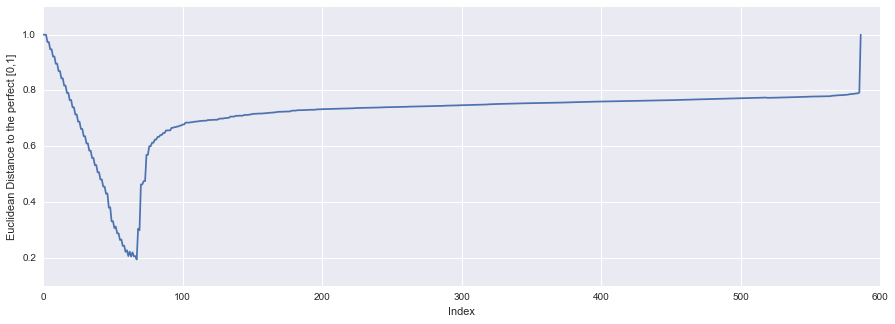

In [561]:
rocZeroOne(y_test, gridSearchLm.best_estimator_.predict_proba(X_test))

Classification Report:

             precision    recall  f1-score   support

          0       1.00      0.82      0.90     23962
          1       0.01      0.89      0.02        38

avg / total       1.00      0.82      0.90     24000


 Confusion matrix, without normalization: 

[[19708  4254]
 [    4    34]]

 Normalized confusion matrix 

[[ 0.82246891  0.17753109]
 [ 0.10526316  0.89473684]]


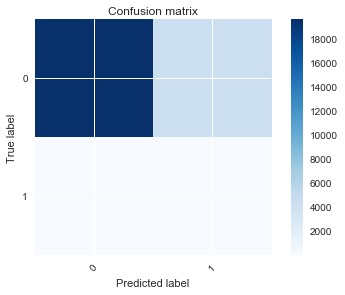

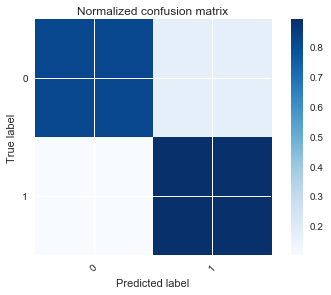

In [533]:
proba = gridSearchLm.best_estimator_.predict_proba(X_test)

yHat = pred(0.4739, gridSearchLm.best_estimator_.predict_proba(X_test))

plot_confusion_matrix(y_test, yHat)

### Random Forest Classifier

In [ ]:
rfMod = RandomForestClassifier(verbose=2, class_weight={1: weight}).fit(X_train, y_train)

In [539]:
param_dist = {"max_depth": [3, None],
              "n_estimators": randint(1, 5),
              "max_features": randint(1, 11),
              "min_samples_split": randint(1, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [ ]:
randomSearchRf = RandomizedSearchCV(rfMod, param_distributions=param_dist, n_iter=10, scoring='roc_auc').fit(X_train, y_train)

In [543]:
randomSearchRf.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 29}

[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.1s finished



Best point on the ROC: TPR = 5.263%, FPR = 1.828%

Best Cut-Off point: 0.0345


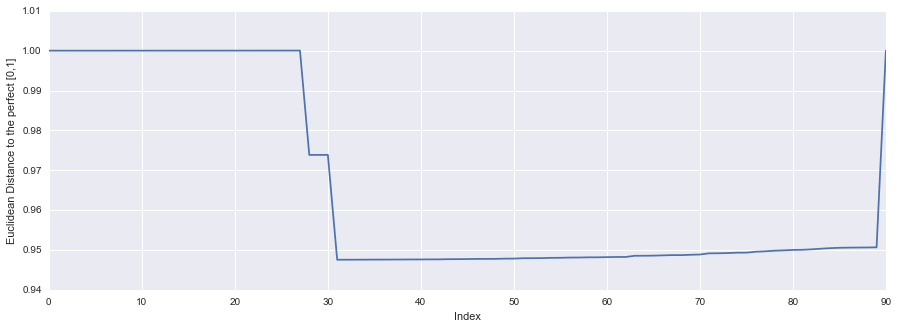

In [544]:
rocZeroOne(y_test, randomSearchRf.best_estimator_.predict_proba(X_test))